# Singapore Government Tender Analysis - Machine Learning Models

This notebook builds and evaluates machine learning models for the Singapore Government Tender dataset. It uses the preprocessed data from the previous notebook and follows the configuration-driven approach.

## Modeling Tasks

1. **Clustering**: Group agencies and suppliers by patterns

Each task uses multiple algorithms with hyperparameter tuning based on the configuration.

In [12]:
# Import required libraries
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import yaml
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.svm import SVC
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           roc_auc_score, confusion_matrix, silhouette_score,
                           calinski_harabasz_score, davies_bouldin_score)
from sklearn.model_selection import cross_val_score

# Add src directory to path
sys.path.append(str(Path().absolute().parent / 'src'))

## 1. Load Configuration and Processed Data

Load the configuration and preprocessed data from the previous notebook.

In [2]:
# Load configuration
config_path = Path().absolute().parent / 'config.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

print(f"Configuration loaded from: {config_path}")
print(f"Project: {config['project']['name']}")
print(f"Version: {config['project']['version']}")

# Load processed data
output_dir = Path().absolute().parent / 'Outputs'
processed_data_path = output_dir / 'tender_data_processed.csv'
df_processed = pd.read_csv(processed_data_path)

print(f"\nProcessed data loaded: {df_processed.shape}")
print(f"Columns: {df_processed.columns.tolist()}")

# Load preprocessor
preprocessor_path = output_dir / 'preprocessor.pkl'
with open(preprocessor_path, 'rb') as f:
    preprocessor = pickle.load(f)

print(f"\nPreprocessor loaded successfully")

Configuration loaded from: /Users/aamirsyedaltaf/Documents/dos5022/config.yaml
Project: Singapore Government Tender Analysis
Version: 1.0.0

Processed data loaded: (11915, 20)
Columns: ['tender_no', 'tender_description', 'agency', 'award_date', 'tender_detail_status', 'supplier_name', 'awarded_amt', 'award_year', 'award_month', 'award_quarter', 'award_day_of_week', 'description_length', 'description_word_count', 'description_char_count', 'is_awarded', 'log_awarded_amt', 'award_amount_category', 'agency_encoded', 'supplier_name_encoded', 'tender_detail_status_encoded']

Preprocessor loaded successfully


## 2. Prepare Data for Modeling

Prepare datasets for each modeling task using the preprocessor.

In [13]:
# # Prepare data for classification
# print("\n=== Preparing Classification Data ===")
# X_train_clf, X_test_clf, y_train_clf, y_test_clf = preprocessor.prepare_for_modeling(
#     df_processed, target_type='classification'
# )

# print(f"Classification data prepared:")
# print(f"  Training: {X_train_clf.shape}")
# print(f"  Test: {X_test_clf.shape}")

# Prepare clustering features
print("\n=== Preparing Clustering Data ===")
agency_features, supplier_features = preprocessor.prepare_for_modeling(
    df_processed, target_type='clustering'
)

print(f"Clustering data prepared:")
print(f"  Agency features: {agency_features.shape}")
print(f"  Supplier features: {supplier_features.shape}")


=== Preparing Clustering Data ===

=== Preparing Data for Clustering Modeling ===

=== Preparing Data for Clustering ===
Agency features shape: (110, 6)
Supplier features shape: (4133, 6)
Clustering data prepared:
  Agency features: (110, 6)
  Supplier features: (4133, 6)


## 3. Clustering Analysis - Agency and Supplier Grouping

Perform clustering analysis on agencies and suppliers to identify patterns.

In [14]:
def perform_clustering_analysis(features_df, entity_name, config):
    """
    Perform clustering analysis on agency or supplier features
    Clustering by using both might have stronger bias towards larger entities, so separate analyses are done.
    
    Args:
		features_df (pd.DataFrame): DataFrame containing features for clustering
		entity_name (str): 'agency' or 'supplier'
		config (dict): Configuration dictionary
        
    Returns:
		results (dict): Clustering metrics for each algorithm
		clustered_data (dict): DataFrames with cluster labels for each algorithm
		X_scaled (np.ndarray): Scaled feature matrix
    """
    print(f"\n=== Clustering Analysis: {entity_name.title()} ===")
    
    # Prepare features (exclude entity name column)
    feature_cols = [col for col in features_df.columns if col != entity_name.lower()]
    X = features_df[feature_cols].fillna(0)
    
    # Scale features
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    clustering_config = config['models']['clustering']
    algorithms = clustering_config['algorithms']
    hyperparams = clustering_config['hyperparameters']
    
    results = {}
    clustered_data = {}
    
    for algorithm in algorithms:
        print(f"\n--- {algorithm.upper()} Clustering ---")
        
        if algorithm == 'kmeans':
            model = KMeans(**hyperparams['kmeans'])
        elif algorithm == 'hierarchical':
            model = AgglomerativeClustering(**hyperparams['hierarchical'])
        elif algorithm == 'dbscan':
            model = DBSCAN(**hyperparams['dbscan'])
        else:
            continue
        
        # Fit model
        cluster_labels = model.fit_predict(X_scaled)
        
        # Calculate metrics (only if more than 1 cluster and not all noise)
        n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        
        if n_clusters > 1 and len(set(cluster_labels)) > 1:
            silhouette = silhouette_score(X_scaled, cluster_labels)
            ch_score = calinski_harabasz_score(X_scaled, cluster_labels)
            db_score = davies_bouldin_score(X_scaled, cluster_labels)
            
            results[algorithm] = {
                'n_clusters': n_clusters,
                'silhouette_score': silhouette,
                'calinski_harabasz_score': ch_score,
                'davies_bouldin_score': db_score
            }
            
            print(f"Number of clusters: {n_clusters}")
            print(f"Silhouette Score: {silhouette:.4f}")
            print(f"Calinski-Harabasz Score: {ch_score:.4f}")
            print(f"Davies-Bouldin Score: {db_score:.4f}")
            
            # Add cluster labels to data
            clustered_df = features_df.copy()
            clustered_df[f'{algorithm}_cluster'] = cluster_labels
            clustered_data[algorithm] = clustered_df
        else:
            print(f"Could not calculate metrics (n_clusters = {n_clusters})")
    
    return results, clustered_data, X_scaled

# Perform agency clustering
agency_clustering_results, agency_clustered_data, agency_X_scaled = perform_clustering_analysis(
    agency_features, 'agency', config
)

# Perform supplier clustering
supplier_clustering_results, supplier_clustered_data, supplier_X_scaled = perform_clustering_analysis(
    supplier_features, 'supplier', config
)


=== Clustering Analysis: Agency ===

--- KMEANS Clustering ---
Number of clusters: 5
Silhouette Score: 0.5178
Calinski-Harabasz Score: 138.7507
Davies-Bouldin Score: 0.7036

--- HIERARCHICAL Clustering ---
Number of clusters: 5
Silhouette Score: 0.4988
Calinski-Harabasz Score: 126.6057
Davies-Bouldin Score: 0.8202

--- DBSCAN Clustering ---
Could not calculate metrics (n_clusters = 1)

=== Clustering Analysis: Supplier ===

--- KMEANS Clustering ---
Number of clusters: 5
Silhouette Score: 0.7318
Calinski-Harabasz Score: 2529.1183
Davies-Bouldin Score: 0.7500

--- HIERARCHICAL Clustering ---
Number of clusters: 5
Silhouette Score: 0.7632
Calinski-Harabasz Score: 2310.6502
Davies-Bouldin Score: 0.7386

--- DBSCAN Clustering ---
Number of clusters: 3
Silhouette Score: 0.6617
Calinski-Harabasz Score: 520.1958
Davies-Bouldin Score: 1.5975


In [15]:
# Display clustering results
def display_clustering_results(results, entity_name):
    """
    Display clustering results in a formatted table
    """
    if not results:
        print(f"\nNo valid clustering results for {entity_name}")
        return None
    
    results_df = pd.DataFrame(results).T
    results_df = results_df.sort_values('silhouette_score', ascending=False)
    
    print(f"\n=== {entity_name.title()} CLUSTERING COMPARISON ===")
    print(results_df.round(4))
    
    # Find best clustering
    best_clustering = results_df['silhouette_score'].idxmax()
    print(f"\nBest clustering: {best_clustering.upper()} (Silhouette: {results_df.loc[best_clustering, 'silhouette_score']:.4f})")
    
    return results_df, best_clustering

agency_results_df, best_agency_clustering = display_clustering_results(agency_clustering_results, 'Agency')
supplier_results_df, best_supplier_clustering = display_clustering_results(supplier_clustering_results, 'Supplier')


=== Agency CLUSTERING COMPARISON ===
              n_clusters  silhouette_score  calinski_harabasz_score  \
kmeans               5.0            0.5178                 138.7507   
hierarchical         5.0            0.4988                 126.6057   

              davies_bouldin_score  
kmeans                      0.7036  
hierarchical                0.8202  

Best clustering: KMEANS (Silhouette: 0.5178)

=== Supplier CLUSTERING COMPARISON ===
              n_clusters  silhouette_score  calinski_harabasz_score  \
hierarchical         5.0            0.7632                2310.6502   
kmeans               5.0            0.7318                2529.1183   
dbscan               3.0            0.6617                 520.1958   

              davies_bouldin_score  
hierarchical                0.7386  
kmeans                      0.7500  
dbscan                      1.5975  

Best clustering: HIERARCHICAL (Silhouette: 0.7632)


### We are going to take supplier clustering instead of agency clustering
- more data points
- better cluster separation
- more interesting individual clusters (upon manual analysis)


### Next steps:
- research at a cluster level what suppliers are clustered together
- assign appropriate cluster names for the supplier names + draw a pie chart of their value
- explore if clusters should be combined/separated further based on subjective analysis and external research

## 4. Visualizations

Create visualizations to better understand the model performance and clustering results.

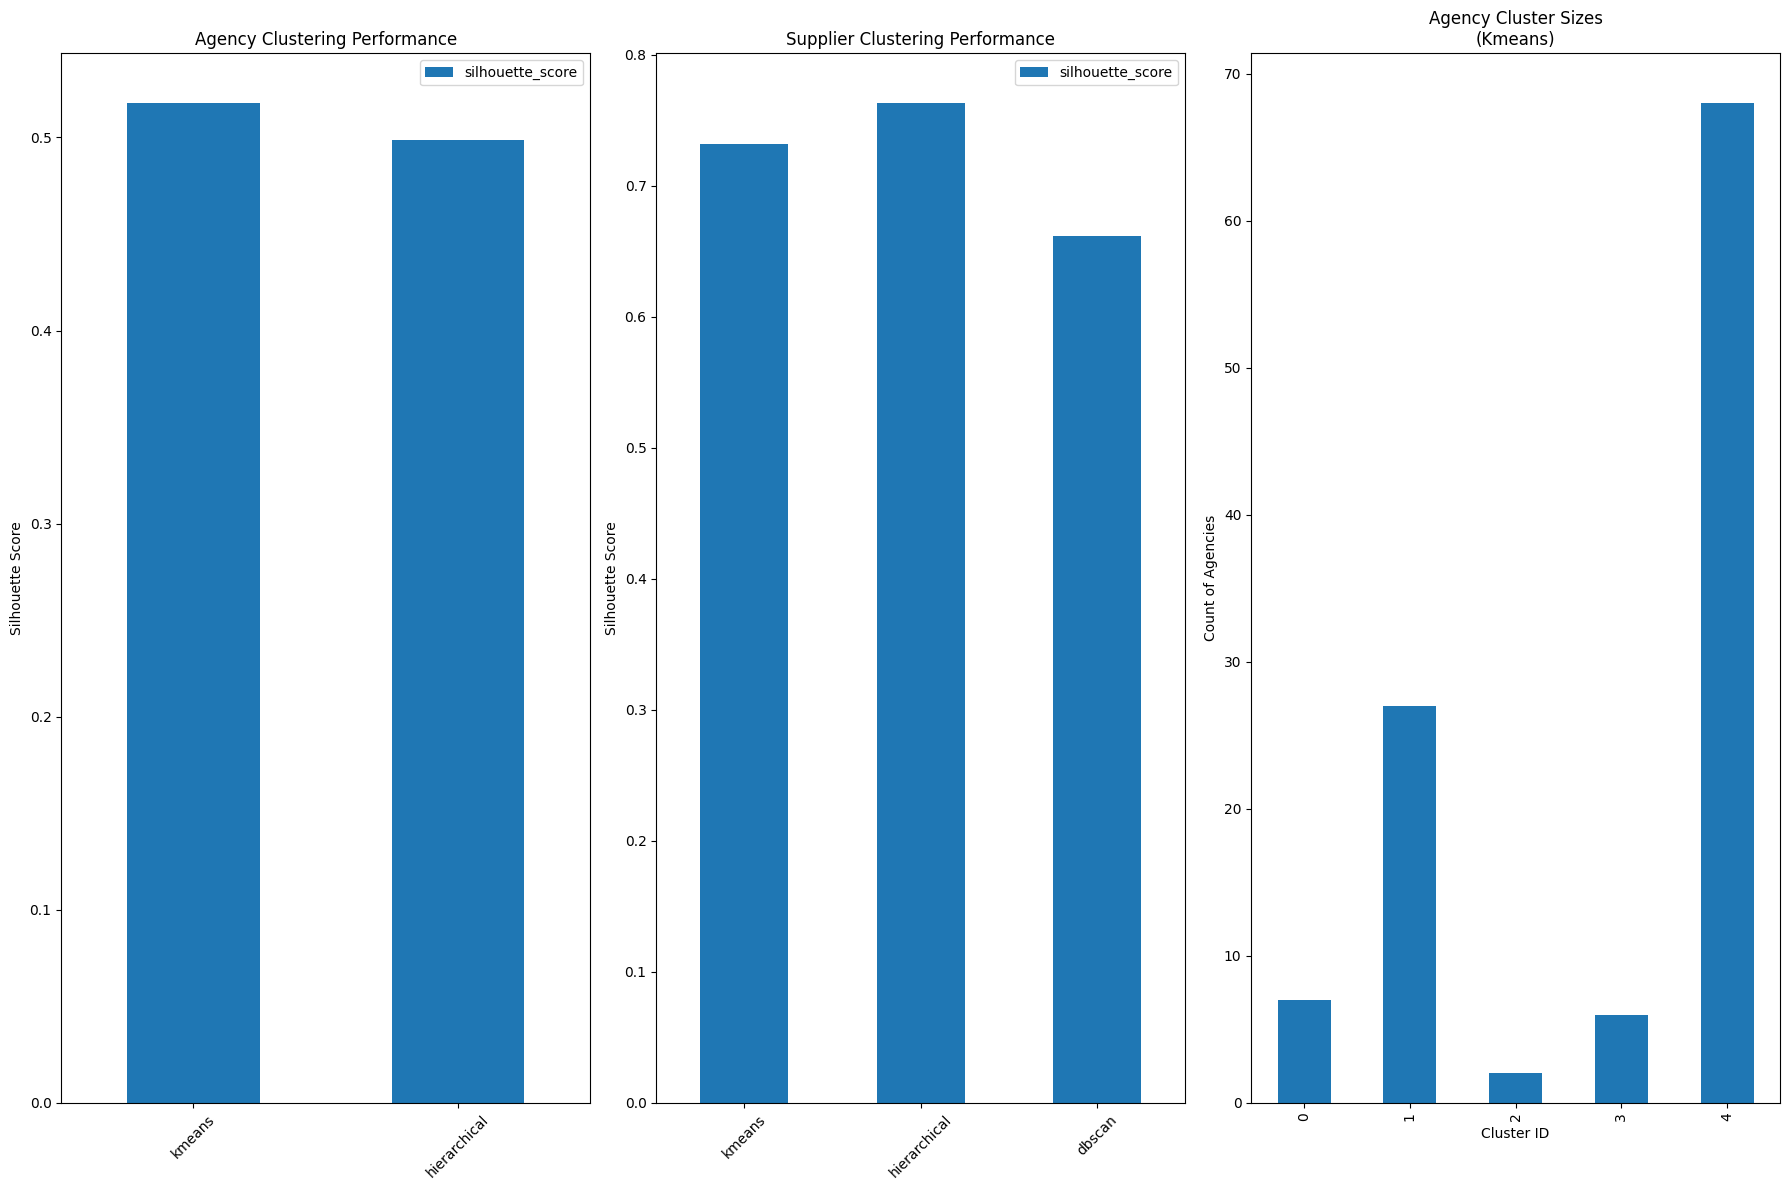

In [19]:
# Create visualization plots
def create_visualizations(agency_clustered_data, supplier_clustered_data):
    """
    Create comprehensive visualizations of results
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 12))
    
    # 4. Clustering Results - Agencies
    if agency_clustering_results:
        agency_df = pd.DataFrame(agency_clustering_results).T
        agency_df.plot(y='silhouette_score', kind='bar', ax=axes[0])
        axes[0].set_title('Agency Clustering Performance')
        axes[0].set_ylabel('Silhouette Score')
        axes[0].tick_params(axis='x', rotation=45)
    
    # 5. Clustering Results - Suppliers
    if supplier_clustering_results:
        supplier_df = pd.DataFrame(supplier_clustering_results).T
        supplier_df.plot(y='silhouette_score', kind='bar', ax=axes[1])
        axes[1].set_title('Supplier Clustering Performance')
        axes[1].set_ylabel('Silhouette Score')
        axes[1].tick_params(axis='x', rotation=45)
        
    
    # 6. Cluster Size Distribution (best clustering)
    if agency_clustered_data and best_agency_clustering in agency_clustered_data:
        cluster_sizes = agency_clustered_data[best_agency_clustering][f'{best_agency_clustering}_cluster'].value_counts().sort_index()
        cluster_sizes.plot(kind='bar', ax=axes[2])
        axes[2].set_title(f'Agency Cluster Sizes\n({best_agency_clustering.title()})')
        axes[2].set_xlabel('Cluster ID')
        axes[2].set_ylabel('Count of Agencies')
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Create visualizations
viz_fig = create_visualizations(agency_clustered_data, supplier_clustered_data)

Text(0, 0.5, 'Count of Suppliers')

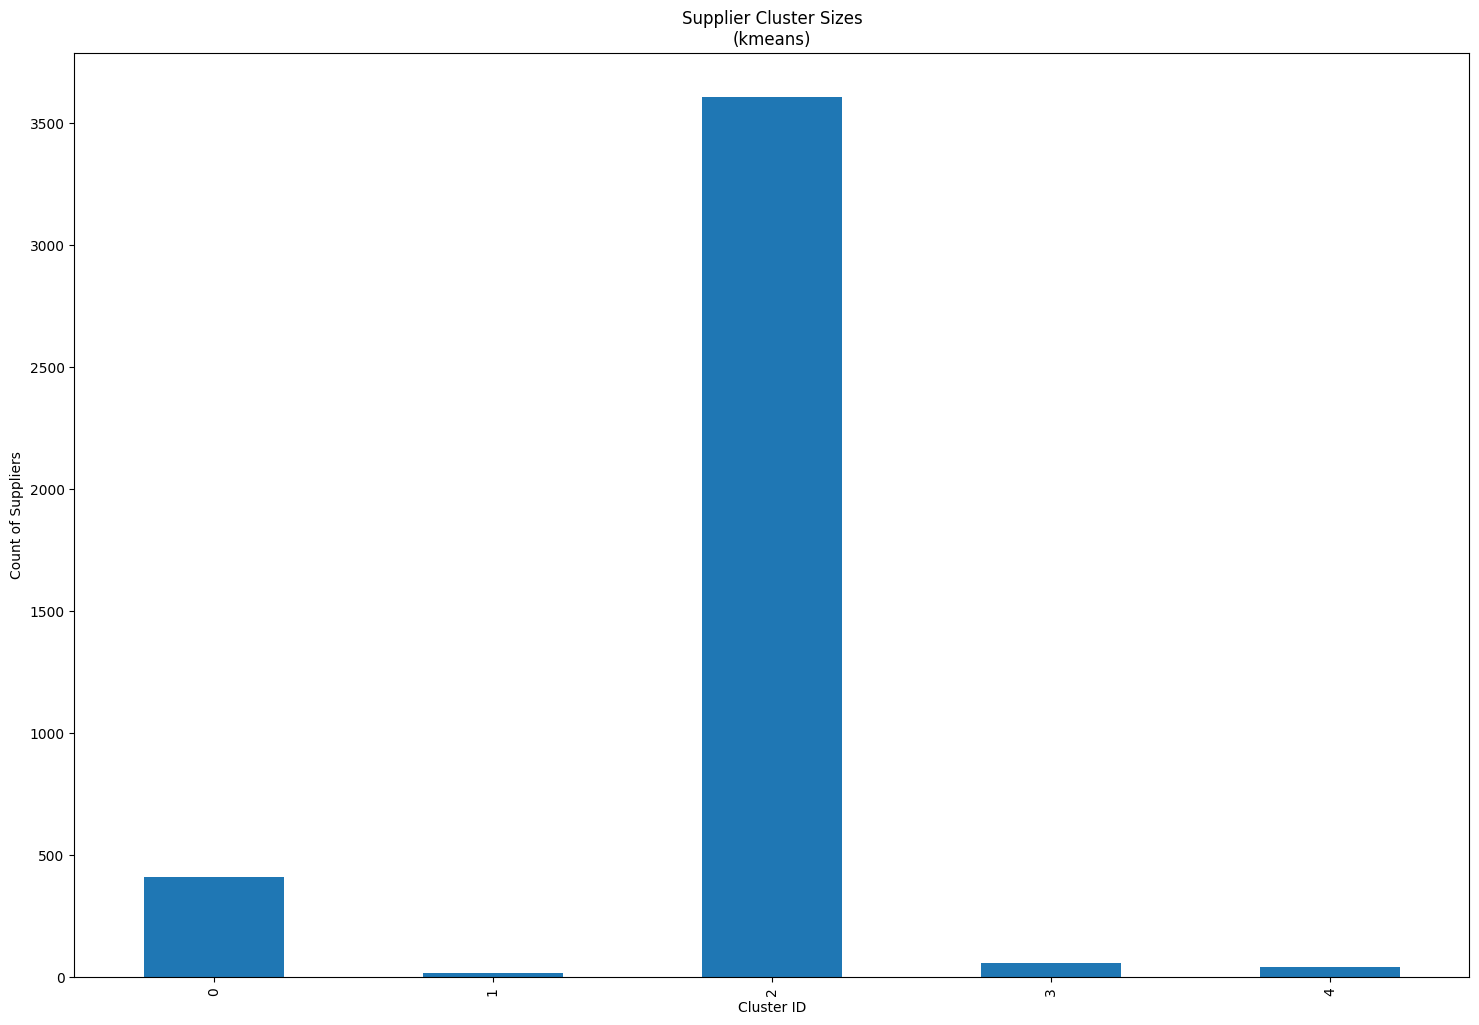

In [25]:
#NOTE: we chose kmeans instead of hierarchical for supplier clustering because kmeans assigns every point to a cluster, while hierarchical may leave some points unclustered depending on the distance threshold.

fig, axes = plt.subplots(1, 1, figsize=(18, 12))
# cluster_sizes = supplier_clustered_data[best_supplier_clustering][f'{best_supplier_clustering}_cluster'].value_counts().sort_index()
cluster_sizes = supplier_clustered_data['kmeans']['kmeans_cluster'].value_counts().sort_index()
cluster_sizes.plot(kind='bar', ax=axes)
axes.set_title(f'Supplier Cluster Sizes\n(kmeans)')
axes.set_xlabel('Cluster ID')
axes.set_ylabel('Count of Suppliers')


## 5. Feature Importance Analysis

Analyze feature importance for the best regression and classification models.


=== Feature Importance - REGRESSION (RANDOM_FOREST) ===
                        feature    importance
3                   awarded_amt  9.999861e-01
0                agency_encoded  5.047473e-06
4            description_length  3.285888e-06
1         supplier_name_encoded  2.288967e-06
5        description_word_count  1.676447e-06
2  tender_detail_status_encoded  6.366683e-07
6                    award_year  3.740154e-07
7                   award_month  3.505327e-07
8                 award_quarter  2.552293e-07


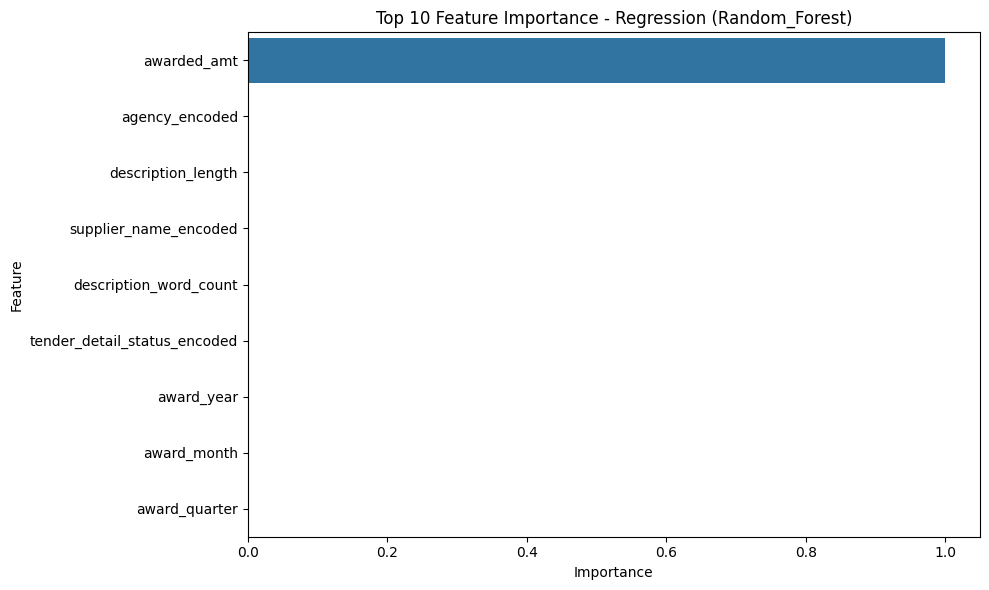


=== Feature Importance - CLASSIFICATION (RANDOM_FOREST) ===
                        feature  importance
3                   awarded_amt    0.560298
1         supplier_name_encoded    0.296554
2  tender_detail_status_encoded    0.139409
0                agency_encoded    0.002178
4            description_length    0.000791
5        description_word_count    0.000234
7                   award_month    0.000212
6                    award_year    0.000187
8                 award_quarter    0.000138


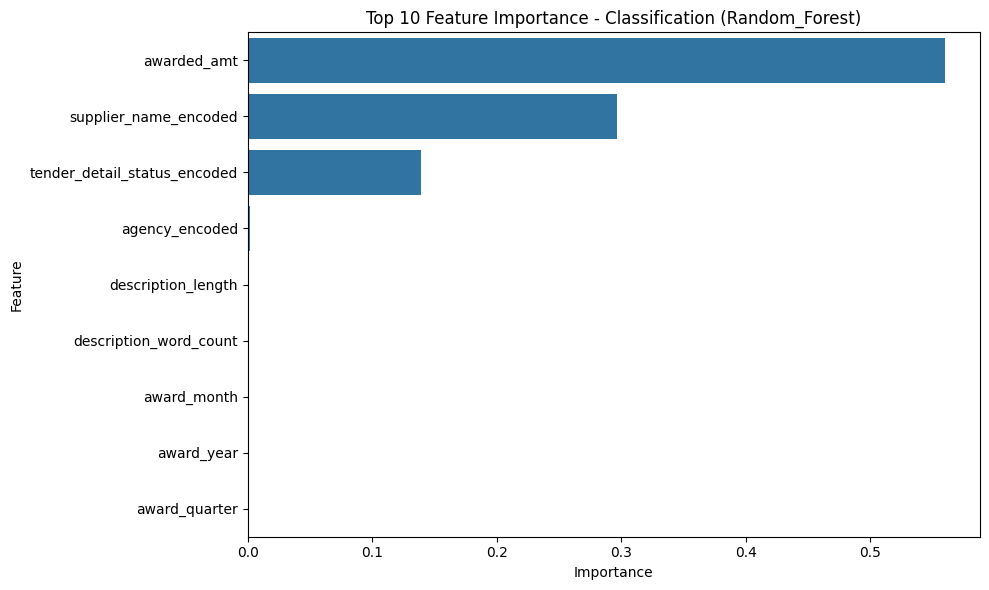

In [ ]:
def analyze_feature_importance(model, feature_names, model_type="model"):
    """
    Analyze and display feature importance
    """
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        
        # Create DataFrame for visualization
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        print(f"\n=== Feature Importance - {model_type.upper()} ===")
        print(importance_df.head(10))
        
        # Plot feature importance
        plt.figure(figsize=(10, 6))
        top_features = importance_df.head(10)
        sns.barplot(x='importance', y='feature', data=top_features, orient='h')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.title(f'Top 10 Feature Importance - {model_type.title()}')
        plt.tight_layout()
        plt.show()
        
        return importance_df
    else:
        print(f"\nModel {model_type} does not have feature_importances_ attribute")
        return None

# Get feature names from the preprocessor's logic
def get_feature_names_from_config(config, df_columns, target_type):
    target = config['targets'][target_type]['primary']
    
    feature_cols = []
    categorical_cols = config['features']['categorical_features']
    numerical_cols = config['features']['numerical_features']

    # Add encoded categorical features
    for col in categorical_cols:
        encoded_col = f'{col}_encoded'
        if encoded_col in df_columns:
            feature_cols.append(encoded_col)

    # Add numerical features
    for col in numerical_cols:
        if col in df_columns and col != target:
            feature_cols.append(col)
            
    return feature_cols

reg_feature_names = get_feature_names_from_config(config, df_processed.columns, 'regression')
clf_feature_names = get_feature_names_from_config(config, df_processed.columns, 'classification')

## 6. Save Models and Results

Save all trained models and results for future use.

In [ ]:
# Create models directory
models_dir = Path().absolute().parent / 'models'
models_dir.mkdir(exist_ok=True)

# # Save classification models
# print("\nSaving classification models...")
# for name, model_data in clf_models.items():
#     model_path = models_dir / f'award_status_classifier_{name}.pkl'
#     with open(model_path, 'wb') as f:
#         pickle.dump(model_data, f)
#     print(f"  Saved: {model_path}")

# Save clustering results
# print("\nSaving clustering results...")
for name, clustered_df in agency_clustered_data.items():
    cluster_path = output_dir / f'agency_clusters_{name}.csv'
    clustered_df.to_csv(cluster_path, index=False)
    print(f"  Saved: {cluster_path}")

for name, clustered_df in supplier_clustered_data.items():
    cluster_path = output_dir / f'supplier_clusters_{name}.csv'
    clustered_df.to_csv(cluster_path, index=False)
    print(f"  Saved: {cluster_path}")

# Save results summary
results_summary = {
    'agency_clustering': agency_clustering_results,
    'supplier_clustering': supplier_clustering_results,
    'best_agency_clustering': best_agency_clustering,
    'best_supplier_clustering': best_supplier_clustering
}

results_path = output_dir / 'modeling_results_summary.pkl'
with open(results_path, 'wb') as f:
    pickle.dump(results_summary, f)
# print(f"\nResults summary saved to: {results_path}")

# Also save as JSON for human readability
import json
json_results_path = output_dir / 'modeling_results_summary.json'
with open(json_results_path, 'w') as f:
    json.dump(results_summary, f, indent=2, default=str)
# print(f"Human-readable results saved to: {json_results_path}")